In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import pyabc

import healpy as hp
from scipy.special import sph_harm
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import dipole
import multipoles
import generate_mocks as gm

In [3]:
plt.rcParams["font.family"] = "serif"

## quasar catalogs

In [4]:
blim = 30
nside_hi = 64
resdir = '/scratch/aew492/lss-dipoles_results/results'

In [5]:
# expected dipole direction
cmb_dipdir = dipole.cmb_dipole()[1]

#### Quaia

In [6]:
# selfunc
selfunc_quaia = gm.get_selfunc_map('quaia_G20.0_zodi', nside=nside_hi, blim=blim)

# load data
# masked
quaia_qmap = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked.npy'))
# the above map smoothed to 1sr
quaia_qmap_smoothed = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked_smoothed_1sr.npy'))
# correct by selfunc
quaia_qmap_corr = quaia_qmap / selfunc_quaia
# load the selfunc-corrected, smoothed map
quaia_qmap_corr_smoothed = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked_corr_smoothed_1sr.npy'))

# base rate for mocks
base_rate_quaia = 33.6330

In [7]:
# hp.fit_dipole result
hp_dipole_quaia = hp.fit_dipole(quaia_qmap_corr)[1] / hp.fit_dipole(quaia_qmap_corr)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_quaia)
dipamp, dipdir.galactic

(0.012918253969369827,
 <SkyCoord (Galactic): (l, b) in deg
     (303.15911297, 28.84933189)>)

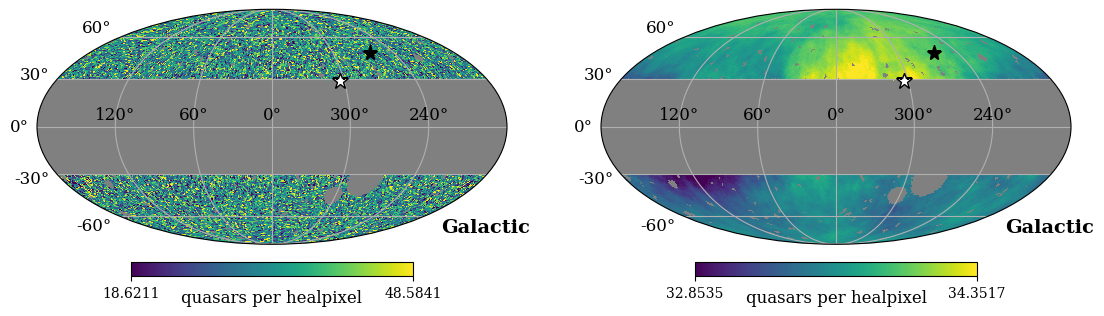

In [8]:
# plot
fig = plt.figure(figsize=(11,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
mean, std = np.nanmean(quaia_qmap_corr), np.nanstd(quaia_qmap_corr)
hp.projview(quaia_qmap_corr, min=mean-2*std, max=mean+2*std, title='', sub=(1,2,1), **kwargs)
tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='k', mec='k', ms=11)
tools.label_coord('Galactic', fs=14)
hp.projview(quaia_qmap_corr_smoothed, min=mean-0.1*std, max=mean+0.1*std, title='', sub=(1,2,2), **kwargs)
tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='k', mec='k', ms=11)
tools.label_coord('Galactic', fs=14)

#### CatWISE

In [18]:
# selfunc
selfunc_catwise_elatcorr = gm.get_selfunc_map('catwise_elatcorr', nside=nside_hi, blim=blim)
selfunc_catwise_zodi = gm.get_selfunc_map('catwise_zodi', nside=nside_hi, blim=blim)
selfunc_catwise = gm.get_selfunc_map('catwise', nside=nside_hi, blim=blim)

# load data
# masked
catwise_qmap = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked.npy'))
# the above map smoothed to 1sr
catwise_qmap_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_smoothed_1sr.npy'))
# selfunc-corrected
catwise_qmap_corr_elatcorr = catwise_qmap / selfunc_catwise_elatcorr
catwise_qmap_corr_zodi = catwise_qmap / selfunc_catwise_zodi
# selfunc-corrected and smoothed
# catwise_qmap_corr_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_corr_smoothed_1sr.npy'))
# catwise_qmap_corr_elatcorr_smoothed = tools.smooth_map(catwise_qmap_corr_elatcorr, sr=1)
catwise_qmap_corr_zodi_smoothed = tools.smooth_map(catwise_qmap_corr_zodi, sr=1)

# base rate for mocks
base_rate_catwise = 77.4495

KeyboardInterrupt: 

In [10]:
# hp.fit_dipole result with elatcorr (should match S21 result)
hp_dipole_catwise = hp.fit_dipole(catwise_qmap_corr_elatcorr)[1] / hp.fit_dipole(catwise_qmap_corr_elatcorr)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_catwise)
dipamp, dipdir.galactic

(0.015334348323861371,
 <SkyCoord (Galactic): (l, b) in deg
     (237.73551446, 28.88093137)>)

In [11]:
# hp.fit_dipole result with selfunc including zodi
hp_dipole_catwise = hp.fit_dipole(catwise_qmap_corr_zodi)[1] / hp.fit_dipole(catwise_qmap_corr_zodi)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_catwise)
dipamp, dipdir.galactic

(0.012374339860876405,
 <SkyCoord (Galactic): (l, b) in deg
     (191.77921627, 34.8197164)>)

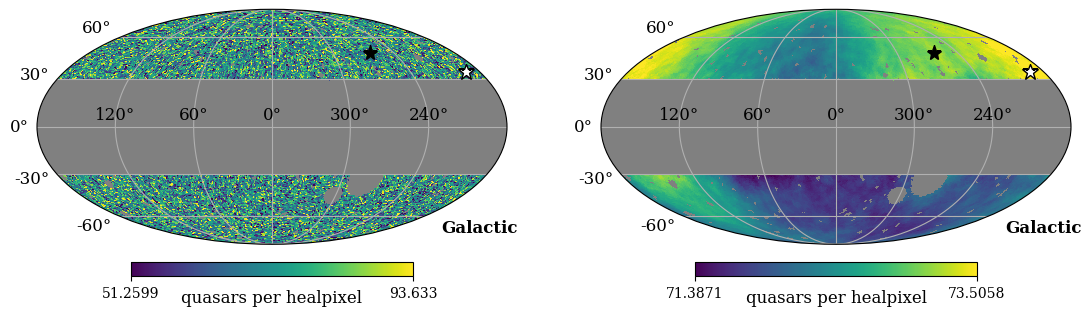

In [12]:
# plot
fig = plt.figure(figsize=(11,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
mean, std = np.nanmean(catwise_qmap_corr_zodi), np.nanstd(catwise_qmap_corr_zodi)
hp.projview(catwise_qmap_corr_zodi, min=mean-2*std, max=mean+2*std, title='', sub=(1,2,1), **kwargs)
tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='k', mec='k', ms=11)
tools.label_coord('Galactic', fs=12)
hp.projview(catwise_qmap_corr_zodi_smoothed, min=mean-0.1*std, max=mean+0.1*std, title='', sub=(1,2,2), **kwargs)
tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='k', mec='k', ms=11)
tools.label_coord('Galactic', fs=12)

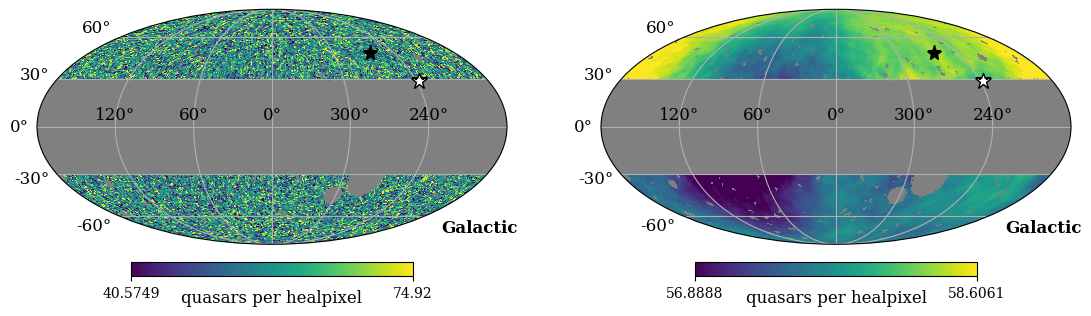

In [11]:
# plot
fig = plt.figure(figsize=(11,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
mean, std = np.nanmean(catwise_qmap_corr_elatcorr), np.nanstd(catwise_qmap_corr_elatcorr)
hp.projview(catwise_qmap_corr_elatcorr, min=mean-2*std, max=mean+2*std, title='', sub=(1,2,1), **kwargs)
tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='k', mec='k', ms=11)
tools.label_coord('Galactic', fs=12)
hp.projview(catwise_qmap_corr_elatcorr_smoothed, min=mean-0.1*std, max=mean+0.1*std, title='', sub=(1,2,2), **kwargs)
tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='k', mec='k', ms=11)
tools.label_coord('Galactic', fs=12)

#### selection functions

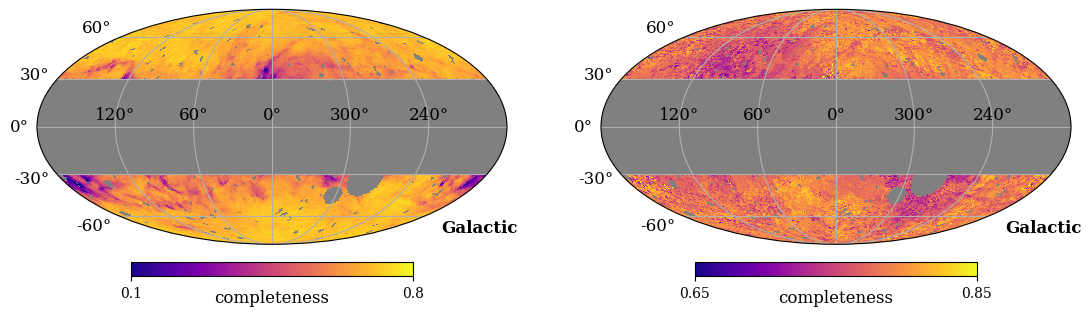

In [13]:
# plot
fig = plt.figure(figsize=(11,4))
kwargs = dict(coord=['C','G'], cmap='plasma', unit='completeness', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
selfunc_quaia_ = np.copy(selfunc_quaia)
selfunc_quaia_[selfunc_quaia <= 0.] = np.nan
selfunc_catwise_ = np.copy(selfunc_catwise_zodi)
selfunc_catwise_[selfunc_catwise_zodi <= 0.] = np.nan
hp.projview(selfunc_quaia_, title='', min=0.1, max=0.8, sub=(1,2,1), **kwargs)
tools.label_coord('Galactic', fs=12)
hp.projview(selfunc_catwise_, title='', min=0.65, max=0.85, sub=(1,2,2), **kwargs)
tools.label_coord('Galactic', fs=12)

### dipole templates

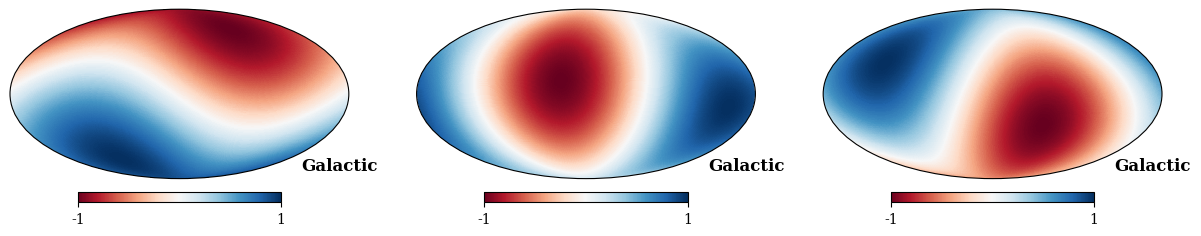

In [13]:
fig = plt.figure(figsize=(12,3))
comps = np.column_stack((np.zeros(3), np.diag([1, 1, 1])))
for i, comp in enumerate(comps):
    hp.projview(dipole.dipole_map(comp), coord=['C','G'], sub=(1, 3, i+1), cmap='RdBu', fig=fig, title='', min=-1, max=1)
    tools.label_coord('Galactic', fs=12)

### example mock generated from sky model

In [14]:
def case_dir(dipamp, log_excess, base_rate, selfunc_str, tag=''):
    return os.path.join(resdir, 'ABC/fake_data', f'dipole-{dipamp:.4f}_excess-1e{log_excess}_base-rate-{base_rate:.4f}{selfunc_str}{tag}')

In [15]:
input_dipamp = 0.0052
input_log_excess = -6.0
base_rate = 33.6330

nmocks = 500
ngens = 15

resdict = np.load(os.path.join(case_dir(input_dipamp, input_log_excess, base_rate, ''),
                               f'{nmocks}mocks_{ngens}gens_2025-03-03', 'results.npy'),
                  allow_pickle=True).item()
data = resdict['data']  # the data as raw quasar counts
selfunc = resdict['selfunc']
observation = resdict['observation']  # the data as overdensity
history = resdict['history']  # History object
prior = resdict['prior']  # dictionary
posterior = resdict['posterior']  # pandas dataframe and weights associated with the final posterior
old_posteriors = resdict['old_posteriors']  # posteriors from the otehr generations

In [16]:
# get the excess (all multipoles and dipole only) maps from the stored alms
excess_map = hp.sphtfunc.alm2map(data['alms'], 64)
excess_dipmap = hp.sphtfunc.alm2map(data['alms'][:3], 64)

# and the input kinematic dipole
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
kinematic_comps = tools.spherical_to_cartesian(r=input_dipamp,
                                    theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                    phi=cmb_dipdir.icrs.ra.rad)
kinematic_dipmap = dipole.dipole_map([0., *kinematic_comps])

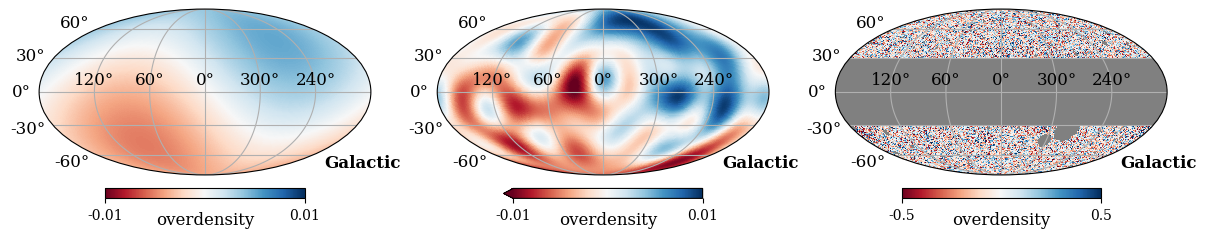

In [17]:
fig = plt.figure(figsize=(12,3))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='overdensity', fig=fig, title='', graticule=True, graticule_labels=True)
hp.projview(kinematic_dipmap, min=-0.01, max=0.01, sub=(1,3,1), **kwargs)
tools.label_coord('Galactic', fs=12)
hp.projview(excess_map + kinematic_dipmap, min=-0.01, max=0.01, sub=(1,3,2), **kwargs)
tools.label_coord('Galactic', fs=12)

datamap = data['data'].astype(float)
datamap[datamap == 0.] = np.nan
datamap_corr = datamap / selfunc
odmap_final = datamap_corr / np.nanmean(datamap_corr) - 1
hp.projview(odmap_final, min=-0.5, max=0.5, sub=(1,3,3), **kwargs)
tools.label_coord('Galactic', fs=12)

### "standard" dipole result (*note no regularization*)

#### Quaia

In [14]:
# hp.fit_dipole result
hp_dipole_quaia = hp.fit_dipole(quaia_qmap_corr)[1] / hp.fit_dipole(quaia_qmap_corr)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_quaia)
dipamp, dipdir.galactic

(0.012918253969369827,
 <SkyCoord (Galactic): (l, b) in deg
     (303.15911297, 28.84933189)>)

In [42]:
# my function
# convert to overdensity map
odmap_quaia_corr = quaia_qmap_corr / np.nanmean(quaia_qmap_corr) - 1

# without weighting by selection function in fit (Cinv=identity) (this should match hp.fit_dipole)
dipamp1, dipdir1 = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_quaia_corr, 0., selfunc=None))
dirstr1 = f"({dipdir1.galactic.l.deg:.1f}, {dipdir1.galactic.b.deg:.1f})"
sep1 = dipdir1.separation(cmb_dipdir)

# with the Quaia selection function as Cinv in the fit
dipamp2, dipdir2 = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_quaia_corr, 0., selfunc=selfunc_quaia))
dirstr2 = f"({dipdir2.galactic.l.deg:.1f}, {dipdir2.galactic.b.deg:.1f})"
sep2 = dipdir2.separation(cmb_dipdir)

# expected amplitude
cmb_dipamp = 0.0052

# fancy print statements
print(f"{'selection function:':<35}{'Dipole amp:':<20}{'Relative to expected:':<25}{'Dipole dir: (l, b) (deg)':<30}{'Angle to CMB dipole (deg):'}")
print('=' * 140)
print(f"{'none:':<35}{dipamp1:<20.5f}{dipamp1 / cmb_dipamp:<25.2f}{dirstr1:<30}{sep1.deg:.2f}")
print(f"{'Quaia with zodi:':<35}{dipamp2:<20.5f}{dipamp2 / cmb_dipamp:<25.2f}{dirstr2:<30}{sep2.deg:.2f}")

selection function:                Dipole amp:         Relative to expected:    Dipole dir: (l, b) (deg)      Angle to CMB dipole (deg):
none:                              0.01292             2.48                     (303.2, 28.8)                 35.61
Quaia with zodi:                   0.01173             2.26                     (298.9, 30.8)                 31.58


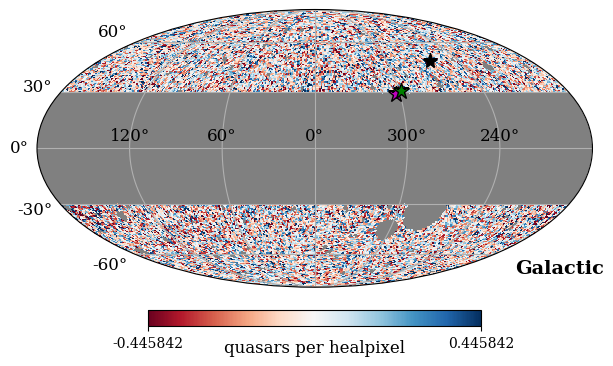

In [16]:
# plot
fig = plt.figure(figsize=(13,5))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='quasars per healpixel', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
std = np.nanstd(odmap_quaia_corr)

hp.projview(odmap_quaia_corr, min=-2*std, max=2*std, title='', sub=(1,2,1), **kwargs)
tools.plot_marker(dipdir1.galactic.l, dipdir1.galactic.b, marker='*', color='m', mec='k', ms=12,
                  label=f'No selection function: |D|={dipamp1:.5f}')
tools.plot_marker(dipdir2.galactic.l, dipdir2.galactic.b, marker='*', color='g', mec='k', ms=12,
                  label=f'No selection function: |D|={dipamp2:.5f}')
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='k', mec='k', ms=11)
tools.label_coord('Galactic', fs=14)
# plt.gca().legend()  # this crashes the cell for some reason

#### CatWISE

In [45]:
# hp.fit_dipole result (*we expect this to be the S21 result, since we've corrected with 'elatcorr' selfunc*)
hp_dipole_catwise = hp.fit_dipole(catwise_qmap_corr_elatcorr)[1] / hp.fit_dipole(catwise_qmap_corr_elatcorr)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_catwise)
dirstr = f"({dipdir.galactic.l.deg:.1f}, {dipdir.galactic.b.deg:.1f})"
sep = dipdir.separation(cmb_dipdir)
dipamp, dipdir.galactic

(0.015334348323861371,
 <SkyCoord (Galactic): (l, b) in deg
     (237.73551446, 28.88093137)>)

In [46]:
# load relevant selfuncs
selfunc_catwise = gm.get_selfunc_map('catwise', nside=nside_hi, blim=blim)
selfunc_catwise_zodi = gm.get_selfunc_map('catwise_zodi', nside=nside_hi, blim=blim)
selfunc_catwise_elatcorr = gm.get_selfunc_map('catwise_elatcorr', nside=nside_hi, blim=blim)

# expected amplitude
cmb_dipamp = 0.0074

# fancy print statements
print(f"{'selection function:':<35}{'Dipole amp:':<20}{'Relative to expected:':<25}{'Dipole dir: (l, b) (deg)':<30}Angle to CMB dipole (deg):")
print('=' * 130)
print(f"{'none:':<35}{dipamp:<20.5f}{dipamp / cmb_dipamp:<25.2f}{dirstr:<30}{sep.deg:.2f}")

tags = ['CatWISE fiducial:', 'CatWISE zodi:', 'CatWISE elatcorr (S21):']
odmaps_catwise_corr = []
dipdirs = []
for i, selfunc in enumerate([selfunc_catwise, selfunc_catwise_zodi, selfunc_catwise_elatcorr]):
    qmap_corr = catwise_qmap / selfunc
    odmap = qmap_corr / np.nanmean(qmap_corr) - 1
    odmaps_catwise_corr.append(odmap)
    dipamp, dipdir = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap, 0., selfunc=selfunc))
    dirstr = f"({dipdir.galactic.l.deg:.1f}, {dipdir.galactic.b.deg:.1f})"
    sep = dipdir.separation(cmb_dipdir)
    dipdirs.append(dipdir)
    print(f"{tags[i]:<35}{dipamp:<20.5f}{dipamp / cmb_dipamp:<25.2f}{dirstr:<30}{sep.deg:.2f}")

selection function:                Dipole amp:         Relative to expected:    Dipole dir: (l, b) (deg)      Angle to CMB dipole (deg):
none:                              0.01533             2.07                     (237.7, 28.9)                 27.83
CatWISE fiducial:                  0.01156             1.56                     (197.2, 43.8)                 45.19
CatWISE zodi:                      0.01245             1.68                     (191.4, 34.7)                 53.97
CatWISE elatcorr (S21):            0.01532             2.07                     (238.0, 28.8)                 27.75


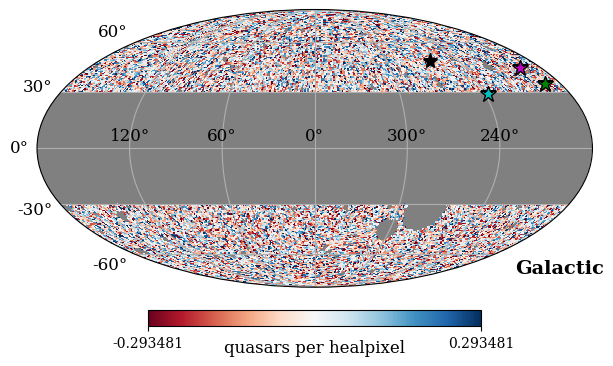

In [20]:
# plot
fig = plt.figure(figsize=(13,5))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='quasars per healpixel', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
std = np.nanstd(odmaps_catwise_corr[0])

hp.projview(odmaps_catwise_corr[0], min=-2*std, max=2*std, title='', sub=(1,2,1), **kwargs)
for c, dipdir in zip(['m', 'g', 'c'], dipdirs):
    tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color=c, mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='k', mec='k', ms=11)
tools.label_coord('Galactic', fs=14)
# plt.gca().legend()  # this crashes the cell for some reason

## ABC results

In [22]:
resdir = '/scratch/aew492/lss-dipoles_results/results'
nside = 1

### Quaia G<20.0 with zodi

In [30]:
res = np.load(os.path.join(resdir, f'ABC/quaia_G20.0_zodi_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
              allow_pickle=True).item()
history = res['history']
prior = res['prior']
posterior = res['posterior']
selfunc = res['selfunc']

# quantiles
df, w = posterior
q_dipamp = tools.quantile(df['dipole_amp'], [0.16, 0.5, 0.84], weights=w)
q_excess = tools.quantile(df['log_excess'], [0.16, 0.5, 0.84], weights=w)

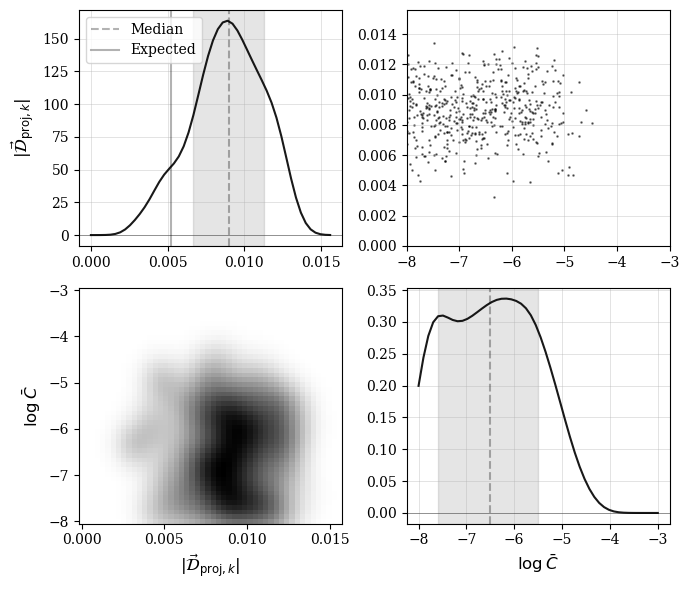

In [31]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(7,6), tight_layout=True)
labels = [r'$|\vec{\mathcal{D}}_{\mathrm{proj},k}|$', r'$\log \bar C$']

df, w = posterior

for i, par_id in enumerate(par_ids):

    # quantiles?
    q = tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w)

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d([df, w], prior, par_id)
    ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)
    ax.axvline(q[1], c='k', alpha=0.3, ls='--', label='Median')
    ax.axvspan(q[0], q[2], color='k', alpha=0.1)
    ax.axhline(0., c='k', alpha=0.5, lw=0.5)
    if par_id == 'dipole_amp':
        ax.axvline(0.0052, c='k', alpha=0.3, lw=1.5, label='Expected')
        ax.legend()
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(labels[i], fontsize=12)
    axs[len(par_ids)-1,i].set_xlabel(labels[i], fontsize=12)
    # axs[i,0].set_xticks(np.linspace(0., 0.02, 5))

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d([df, w], prior, par_ids[j], par_id)
        mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='binary')

        # upper
        ax = axs[j, i]
        tools.scatter([df, w], prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
        ax.grid(alpha=0.5, lw=0.5)

### CatWISE with zodi

In [32]:
res = np.load(os.path.join(resdir, f'ABC/catwise_zodi_dipole_excess_nside{nside}_500mocks_20iters_base-rate-{base_rate_catwise:.4f}/results.npy'),
              allow_pickle=True).item()
history = res['history']
prior = res['prior']
posterior = res['posterior']
selfunc = res['selfunc']

# quantiles
df, w = posterior
q_dipamp = tools.quantile(df['dipole_amp'], [0.16, 0.5, 0.84], weights=w)
q_excess = tools.quantile(df['log_excess'], [0.16, 0.5, 0.84], weights=w)

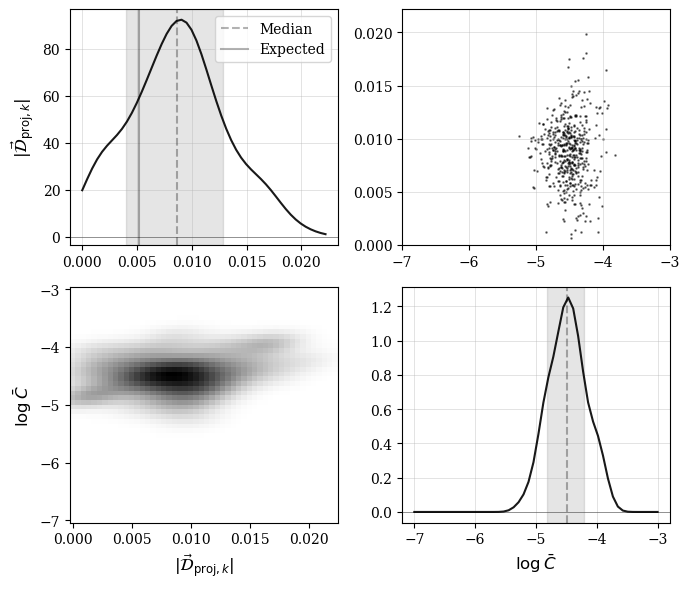

In [33]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(7,6), tight_layout=True)
labels = [r'$|\vec{\mathcal{D}}_{\mathrm{proj},k}|$', r'$\log \bar C$']

df, w = posterior

for i, par_id in enumerate(par_ids):

    # quantiles?
    q = tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w)

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d([df, w], prior, par_id)
    ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)
    ax.axvline(q[1], c='k', alpha=0.3, ls='--', label='Median')
    ax.axvspan(q[0], q[2], color='k', alpha=0.1)
    ax.axhline(0., c='k', alpha=0.5, lw=0.5)
    if par_id == 'dipole_amp':
        ax.axvline(0.0052, c='k', alpha=0.3, lw=1.5, label='Expected')
        ax.legend()
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(labels[i], fontsize=12)
    axs[len(par_ids)-1,i].set_xlabel(labels[i], fontsize=12)
    # axs[i,0].set_xticks(np.linspace(0., 0.02, 5))

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d([df, w], prior, par_ids[j], par_id)
        mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='binary')

        # upper
        ax = axs[j, i]
        tools.scatter([df, w], prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
        ax.grid(alpha=0.5, lw=0.5)